In [29]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [30]:
file_path = 'cluster_new_raw_test.csv'
df = pd.read_csv(file_path)
df.drop(columns=['id'], inplace=True)
df.head()

,EDA,TEMP,BVP,HR,Cluster
0,0.563729,4.00,64.0,1.00,0
1,-0.000000,33.99,-0.0,83.00,0
2,0.382858,33.99,-0.0,83.00,1
3,0.438379,33.99,-0.0,75.33,1
4,0.414428,33.99,-0.0,70.50,1


In [31]:
y = df['Cluster']
y.value_counts()


Cluster
0    240871
1    210399
Name: count, dtype: int64

<Axes: >

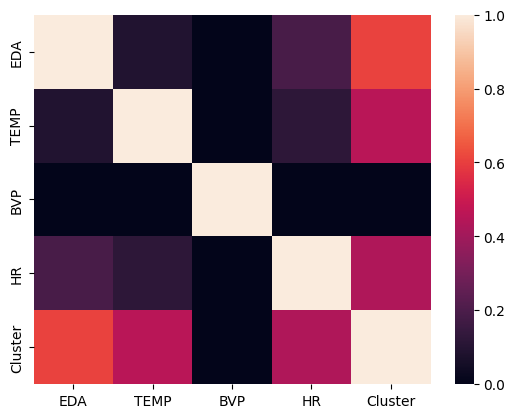

In [32]:
sns.heatmap(df.corr())

In [33]:
import dask.dataframe as dd
import dask.array as da
# from dask_ml.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from dask_ml.model_selection import train_test_split, GridSearchCV
from dask_ml.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [34]:
from dask.distributed import Client
# Set up a Dask client for parallelism
client = Client(n_workers=4, threads_per_worker=2, memory_limit='2GB')
print(client)

<Client: 'tcp://127.0.0.1:56696' processes=4 threads=8, memory=7.45 GiB>


In [35]:
# Load large dataset with Dask
# Replace 'your_large_dataset.csv' with the actual file path
# df = dd.read_csv(file_path)
# converting pandas datafram to dask dataframe
df = dd.from_pandas(df, npartitions=3)
# Inspect the dataset (optional)
df.head()

,EDA,TEMP,BVP,HR,Cluster
0,0.563729,4.00,64.0,1.00,0
1,-0.000000,33.99,-0.0,83.00,0
2,0.382858,33.99,-0.0,83.00,1
3,0.438379,33.99,-0.0,75.33,1
4,0.414428,33.99,-0.0,70.50,1


In [36]:
# raw_data = df.drop('id', axis=1)

# # conversion to pandas
# df = raw_data.compute()

In [37]:
df.head()

,EDA,TEMP,BVP,HR,Cluster
0,0.563729,4.00,64.0,1.00,0
1,-0.000000,33.99,-0.0,83.00,0
2,0.382858,33.99,-0.0,83.00,1
3,0.438379,33.99,-0.0,75.33,1
4,0.414428,33.99,-0.0,70.50,1


In [38]:
# Assume 'target' is the target variable and others are features
target_column = 'Cluster'
X = df.drop(columns=[target_column]).to_dask_array(lengths=True)
y = df[target_column].to_dask_array(lengths=True)

In [39]:
# Apply standardization
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [40]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [41]:
X_train.shape, X_test.shape

((338452, 4), (112818, 4))

In [42]:
# You can tune hyperparameters like 'max_iter' and 'penalty'
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Train the model (fit the data)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [43]:
from dask import delayed
# Define a delayed function to fit and predict
@delayed
def train_and_predict(X_train, y_train, X_test):
    rf.fit(X_train, y_train)
    return rf.predict(X_test)

In [44]:
# Train and predict (this is delayed so it will be executed in parallel)
y_pred = train_and_predict(X_train.compute(), y_train.compute(), X_test.compute())

# Compute the predictions and evaluate
print(classification_report(y_test.compute(), y_pred.compute()))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97     60218
           1       0.95      0.98      0.96     52600

    accuracy                           0.97    112818
   macro avg       0.97      0.97      0.97    112818
weighted avg       0.97      0.97      0.97    112818



In [45]:
accuracy = accuracy_score(y_test.compute(), y_pred.compute())
print(f"Accuracy: {accuracy}")

Accuracy: 0.9663883422858055


### Hyperparameter tuning

In [46]:
#  Define a hyperparameter grid to search over
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 200], 
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [10, 20, 50],
    'bootstrap':[True, False],
    'max_features':[0.2,0.6,1.0],
    'max_samples':[0.5,0.75,1.0],
    'n_estimators':[20,60,100,120]
}

In [48]:
random_forest = RandomForestClassifier()

In [ ]:
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)


# 6. Fit the grid search to the training data
grid_search.fit(X_train, y_train)

('randomforestclassifier-fit-score-a3ba910dba81f8550e6f10e9785d7638', 3022, 0) has failed... retrying
('randomforestclassifier-fit-score-a3ba910dba81f8550e6f10e9785d7638', 3242, 3) has failed... retrying
('randomforestclassifier-fit-score-a3ba910dba81f8550e6f10e9785d7638', 644, 4) has failed... retrying
('randomforestclassifier-fit-score-a3ba910dba81f8550e6f10e9785d7638', 2980, 3) has failed... retrying
('randomforestclassifier-fit-score-a3ba910dba81f8550e6f10e9785d7638', 861, 2) has failed... retrying
('randomforestclassifier-fit-score-a3ba910dba81f8550e6f10e9785d7638', 465, 2) has failed... retrying
('randomforestclassifier-fit-score-a3ba910dba81f8550e6f10e9785d7638', 999, 4) has failed... retrying
('randomforestclassifier-fit-score-a3ba910dba81f8550e6f10e9785d7638', 424, 1) has failed... retrying
('randomforestclassifier-fit-score-a3ba910dba81f8550e6f10e9785d7638', 3753, 2) has failed... retrying
('randomforestclassifier-fit-score-a3ba910dba81f8550e6f10e9785d7638', 248, 4) has faile

In [191]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best hyperparameters:", best_params)
print("Best cross-validation score: {:.4f}".format(best_score))

Best hyperparameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation score: 0.8962


In [193]:
#  Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

from sklearn.metrics import classification_report
# Print classification report for the test set
print("\nClassification Report on Test Data:")
print(classification_report(y_test, y_pred))


Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     60218
           1       0.89      0.90      0.90     52600

    accuracy                           0.90    112818
   macro avg       0.90      0.90      0.90    112818
weighted avg       0.91      0.90      0.91    112818

